# CNNGeometric : Demo on how to apply the transformation

Runs a trained network on an image.

### While I did write some parts for homology, it has not been implemented properly, this is just a "skeleton"/basis for what we will do next

## Imports

In [1]:
from __future__ import print_function, division
import os
import argparse
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from model.cnn_geometric_model import CNNGeometric
from data.pf_dataset import PFDataset
from data.download_datasets import download_PF_willow
from image.normalization import NormalizeImageDict, normalize_image
from util.torch_util import BatchTensorToVars, str_to_bool
from geotnf.transformation import GeometricTnf
from geotnf.point_tnf import *
import matplotlib.pyplot as plt
from skimage import io
import warnings
from torchvision.transforms import Normalize
from collections import OrderedDict

warnings.filterwarnings('ignore')

## Parameters
Need to look at trained_models, but basically here you load the weights for a given model. 

can be 
aff, tps, or hom (for the three types of transformation handled, i.e. affine, thin-plate or homology)

Here, I wrote manually the paths for the models aff and tps. I didn't train any model with homology so far so there's no `model_hom_path`


In [5]:
#Can be 'vgg' or 'resnet101'
feature_extraction_cnn = 'vgg'

if feature_extraction_cnn=='vgg':
    model_aff_path = "trained_models/best_pascal_checkpoint_adam_affine_grid_loss.pth.tar"
    model_tps_path = "trained_models/best_pascal_checkpoint_adam_tps_grid_loss.pth.tar"
    model_hom_path = ''
elif feature_extraction_cnn=='resnet101':
    model_aff_path = 'trained_models/best_pascal_checkpoint_adam_affine_grid_loss_resnet_random.pth.tar'
    model_tps_path = 'trained_models/best_pascal_checkpoint_adam_tps_grid_loss_resnet_random.pth.tar'   
    model_hom_path = ''
    
#This is p straight forward. These are the image source and target
#Here, I simply downloaded two similar looking images from google images, renamed them and put them in this folder. (I manually selected a pair)
source_image_path='datasets/lol/bike1.jpg'
target_image_path='datasets/lol/bike_rider1.jpg'

#Here sets four_points True by default manually for the homology model transform, see below.
#Will change when implementing correctly
four_points = True

In [11]:
feature_extraction_cnn = 'vgg'

model_aff_path = 'trained_models/aff-pascal-vgg/best_aff-pascal-vgg_affine_grid_lossvgg.pth.tar'
model_tps_path = 'trained_models/tps-pascal-vgg/best_tps-pascal-vgg_tps_grid_lossvgg.pth.tar'
model_hom_path = ''

source_image_path='datasets/f1_redbull_source.jpg'
target_image_path='datasets/f1_redbull_target.jpg'

## Load models

We have to initialize them using `CNNGeometric(...)`. Take a look at CNNGeometric to figure out what arguments to use.

Importantly, output_dim specifies the output dimension of the Feature Regressor, and has different dimensions depending on what transformation you use:
(Check `train.py`, at the arguments to understand how they create the network, there are also many different parameters for train.py but this notebook
assumes we have a pre-trained model with a limited set of parameters)
- Affine : output_dim = 6
- Homology : 
    - Four points homology : output_dim = 8
    - Not four points homology : output_dim = 9
- Thin-plate : output_dim = 18

**NOTICE :  Notice the replace 'vgg', model under 'loading trained model weights' should probably change something if we want to use resnet101**

**but I haven't figured it out yet (i.e. how the checkpoint works)**

In [3]:
use_cuda = torch.cuda.is_available()
do_aff = not model_aff_path==''
do_tps = not model_tps_path==''
do_hom = not model_hom_path==''

# Create model
print('Creating CNN model...')

# CREATING MO
if do_aff:
    model_aff = CNNGeometric(output_dim=6,use_cuda=use_cuda,
                             feature_extraction_cnn=feature_extraction_cnn)
if do_tps:
    model_tps = CNNGeometric(output_dim=18,use_cuda=use_cuda,
                             feature_extraction_cnn=feature_extraction_cnn)
#if do_hom:
#    if four_points:
#        model_hom = CNNGeometric(output_dim=8, use_cuda=use_cuda,
#                                feature_extraction_cnn=feature_extraction_cnn)
#    else : 
#        model_hom = CNNGeometric(output_dim=9, use_cuda=use_cuda,
#                        feature_extraction_cnn=feature_extraction_cnn)
# Load trained weights, not much to understand here, it's just that this is how it works.
print('Loading trained model weights...')
if do_aff:
    checkpoint = torch.load(model_aff_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
    model_aff.load_state_dict(checkpoint['state_dict'])
if do_tps:
    checkpoint = torch.load(model_tps_path, map_location=lambda storage, loc: storage)
    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
    model_tps.load_state_dict(checkpoint['state_dict'])

#Once again, while I wrote these lines, there is no model_homo_path trained so this is just for modularity
#if do_hom:
#    checkpoint = torch.load(model_hom_path, map_location=lambda storage, loc: storage)
#    checkpoint['state_dict'] = OrderedDict([(k.replace('vgg', 'model'), v) for k, v in checkpoint['state_dict'].items()])
#    model_hom.load_state_dict(checkpoint['state_dict'])

Creating CNN model...
Loading trained model weights...


## Create image transformers

Define the geometric transformation functions. Check the file containing `GeometricTnf` to see its parameters.

In [12]:
tpsTnf = GeometricTnf(geometric_model='tps', use_cuda=use_cuda)
affTnf = GeometricTnf(geometric_model='affine', use_cuda=use_cuda)
homTnf = GeometricTnf(geometric_model='hom', use_cuda=use_cuda)

## Load and preprocess images

**Notice here, in the original notebook, they use pre-set means and stds, i.e. `normalizeTnf = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
` and we should probably take the means and std from the source image rather than use a preset. 
Take a look at image/normalization.py : normalize_image() to look at parameters, and how we should give the means to them.

In [16]:
#Here resizes to 240x240 with bi-linear sampling
resizeCNN = GeometricTnf(out_h=240, out_w=240, use_cuda = False) 

def alt_preprocess_image(image,means,stds):
    """
    CALLED alt_preprocess_image because it differs a little bit from the one provided in the demo notebook
    """
    # convert to torch Variable
    image = np.expand_dims(image.transpose((2,0,1)),0)
    image = torch.Tensor(image.astype(np.float32)/255.0)
    image_var = Variable(image,requires_grad=False)
    # Resize image using bilinear sampling with identity affine tnf
    image_var = resizeCNN(image_var)
    # Normalize image
    image_var = normalize_image(image_var,mean=means,std=stds)
    return image_var

In [17]:
#Loading images, then converting to tensor so I can read the values of means and STD as to normalize them.
#source_image = io.imread(source_image_path)
#target_image = io.imread(target_image_path)
#
##Convert source image to tensor to extract its means and std for each of the 3 RGB channels
#image_tmp = torch.Tensor(source_image.astype(np.float32)/255.0)
##Getting means/stds
#R_mean, R_std = image_tmp[:,:,0].mean(), image_tmp[:,:,0].std()
#G_mean, G_std = image_tmp[:,:,1].mean(), image_tmp[:,:,1].std()
#B_mean, B_std = image_tmp[:,:,2].mean(), image_tmp[:,:,2].std()
#means = [R_mean, G_mean, B_mean]
#stds = [R_std, G_std, B_std]
#print(means, stds)
#
means=[0.485, 0.456, 0.406]
stds=[0.229, 0.224, 0.225]
normalizeTnf = Normalize(mean = means, std=stds)

In [18]:
#Redundant, reloads the image
source_image = io.imread(source_image_path)
target_image = io.imread(target_image_path)
#Use the preprocess method declared above to resize, normalize using the means and std computed above
source_image_var = alt_preprocess_image(source_image,means=means, stds=stds)
target_image_var = alt_preprocess_image(target_image,means=means, stds=stds)

if use_cuda:
    source_image_var = source_image_var.cuda()
    target_image_var = target_image_var.cuda()
#Create a "batch" (i.e. a pair) for the next cell below
batch = {'source_image': source_image_var, 'target_image':target_image_var}
#Resize target: create a function that will resize a given input into the target_image's dimension
resizeTgt = GeometricTnf(out_h=target_image.shape[0], out_w=target_image.shape[1], use_cuda = use_cuda) 

## Evaluate model

Must set the models to eval mode by using `.eval()` which sets `model.self.training = False` within pytorch.nn.
This sets autograd to False, and prevents the weight to change.

The opposite is model.train() which sets the flag `model.self.training = True`

Then, under #evaluate models, we get the theta_aff or theta_tps (see paper, figure 5) as the estimated parameters for the geometric transformation, and apply them on `batch`.

<img src = 'https://raw.githubusercontent.com/richieYT-wan/CS-433_cnngeometric_pytorch/master/fig5.jpg' width = 500 />


Remember that `batch` is the pair of images. (IA and IB from the paper)


In [19]:
#Set the models to eval mode
if do_aff:
    model_aff.eval()
if do_tps:
    model_tps.eval()
if do_hom:
    model_hom.eval()
    
# Evaluate models and get the thetas
if do_aff:
    theta_aff=model_aff(batch)
    warped_image_aff = affTnf(batch['source_image'],theta_aff.view(-1,2,3))

if do_tps:
    theta_tps=model_tps(batch)
    warped_image_tps = tpsTnf(batch['source_image'],theta_tps)

if do_aff and do_tps:
    theta_aff_tps=model_tps({'source_image': warped_image_aff, 'target_image': batch['target_image']})        
    warped_image_aff_tps = tpsTnf(warped_image_aff,theta_aff_tps)

## Process result

In [20]:
# Un-normalize images and convert to numpy
# I haven't touched anything here.
if do_aff:
    warped_image_aff_np = normalize_image(resizeTgt(warped_image_aff),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()

if do_tps:
    warped_image_tps_np = normalize_image(resizeTgt(warped_image_tps),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()

if do_aff and do_tps:
    warped_image_aff_tps_np = normalize_image(resizeTgt(warped_image_aff_tps),forward=False).data.squeeze(0).transpose(0,1).transpose(1,2).cpu().numpy()


## Display
a simple subplots, I haven't touched anything here.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


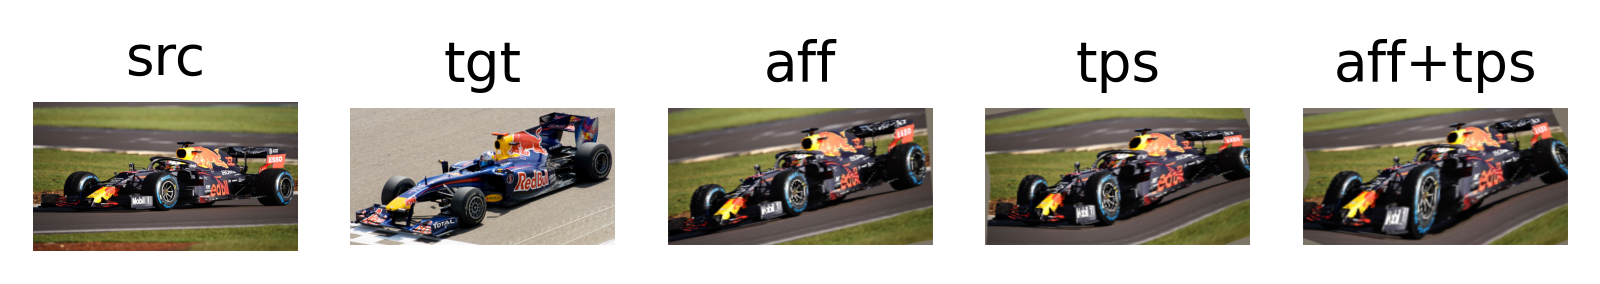

In [21]:
N_subplots = 2+int(do_aff)+int(do_tps)+int(do_aff and do_tps)
fig, axs = plt.subplots(1,N_subplots)
axs[0].imshow(source_image)
axs[0].set_title('src')
axs[1].imshow(target_image)
axs[1].set_title('tgt')
subplot_idx = 2
if do_aff:
    axs[subplot_idx].imshow(warped_image_aff_np)
    axs[subplot_idx].set_title('aff')
    subplot_idx +=1 
if do_tps:
    axs[subplot_idx].imshow(warped_image_tps_np)
    axs[subplot_idx].set_title('tps')
    subplot_idx +=1 
if do_aff and do_tps:
    axs[subplot_idx].imshow(warped_image_aff_tps_np)
    axs[subplot_idx].set_title('aff+tps')

for i in range(N_subplots):
    axs[i].axis('off')

fig.set_dpi(330)
plt.show()